In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import TfidfVectorizer
from malnis import show
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm
# import scipy.sparse as sp
# from sklearn.linear_model import LogisticRegression 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA, SparsePCA
# from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, PrecisionRecallDisplay, RocCurveDisplay
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import pytorch_lightning as pl
import torch.utils.data as tud
import seaborn as sns
sns.set()

/home/jarobyte/envs/malnis/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
# pwd

In [3]:
# The number of sentences in each paper goes from 59 to 4,447. I truncate to 512.

# data = pd.read_pickle("../data/labels.pkl")\
# .reset_index(drop = True)\
# .assign(n_sentences = lambda df: df.sentences.map(len))\
# .assign(
#     sentences = lambda df: df.sentences.map(lambda y: y[:512]),
#     relevance = lambda df: df.relevance.map(lambda y: y[:512]),    
# )
# show(data)

In [4]:
# s = np.array(data.relevance.map(lambda x: [sum(x), len(x)]).tolist()).sum(axis = 0)
# s[0] / s[1]

In [5]:
# data.n_sentences.describe()

In [6]:
# model = SentenceTransformer(
#     "sbert"
# #     'all-MiniLM-L6-v2', 
# #     cache_folder = "../assets"
# #     "../cache/huggingface/transformers/"
# #     cache_folder = "../cache/huggingface/transformers"
# )

# query_embeddings = model.encode(data["query"], show_progress_bar = True)
# print(query_embeddings.shape)

# dims = query_embeddings.shape[1]
# sentence_embeddings = [
#     model.encode(l)#.toarray() 
#     for l in tqdm(data.sentences)
# ]
# print(all([l.shape[1] == dims for l in sentence_embeddings]))

# print(query_embeddings.shape[0] == len(sentence_embeddings))

# print(sum([len(l) for l in tqdm(data.sentences)]))

# train = [
# #     ((sp.csr_matrix(np.ones([l.shape[0],1])) * q) - l).power(2)
# #     (q - l)**2
#     np.concatenate([np.tile(q, (l.shape[0], 1)), l], axis = 1)
#     for q, l in zip(tqdm(query_embeddings), sentence_embeddings)
# ]
# print(len(train))

# X = [torch.tensor(x) for x in train]
# print(all([x.shape[0] <= 512 for x in X]))

# X = torch.nn.utils.rnn.pad_sequence(X, batch_first = True)
# print(X.shape)

# # X = np.concatenate(train)#.toarray().T#.squeeze()
# # print(X.shape)

# torch.save(X, "X_lstm_sbert_concat.pt")

In [7]:
# X = torch.load("X_lstm_sbert_concat.pt")
# X.shape

In [8]:
# Y = torch.tensor([y for l in tqdm(data.relevance) for y in l])
# Y.shape

In [9]:
# Y = torch.nn.utils.rnn.pad_sequence(
#     [torch.tensor(x) for x in data.relevance], 
#     batch_first = True
# )\
# .long()
# Y.shape

In [10]:
# Y.sum()

In [11]:
# X_train, X_test, Y_train, Y_test, relevance_train, relevance_test = train_test_split(
#     X, 
#     Y, 
#     data.relevance, 
#     random_state = 1
# )
# print("X_train", X_train.shape)
# print("X_test", X_test.shape)
# print("Y_train", Y_train.shape)
# print("Y_test", Y_test.shape)

In [12]:
# Y_train.sum(), Y_test.sum()

In [13]:
X_train = torch.tensor(np.load("../data/split/X_train.npy"))
X_train.shape

torch.Size([6723, 512, 768])

In [14]:
Y_train = torch.tensor(np.load("../data/split/Y_train.npy"))
Y_train.shape

torch.Size([6723, 512])

In [15]:
X_test = torch.tensor(np.load("../data/split/X_test.npy"))
X_test.shape

torch.Size([2242, 512, 768])

In [16]:
Y_test = torch.tensor(np.load("../data/split/Y_test.npy"))
Y_test.shape

torch.Size([2242, 512])

In [17]:
relevance_train = pd.read_pickle("../data/split/relevance_train.pkl")
relevance_train.shape

(6723,)

In [18]:
relevance_test = pd.read_pickle("../data/split/relevance_test.pkl")
relevance_test.shape

(2242,)

In [19]:
dataset = tud.TensorDataset(X_train.cuda(), Y_train.cuda())
len(dataset)

6723

In [20]:
loader = tud.DataLoader(
    dataset,
    batch_size = 8,
    shuffle = True
)
[x.shape for x in next(iter(loader))]

[torch.Size([8, 512, 768]), torch.Size([8, 512])]

parameters: 11,089,001


  0%|          | 0/84100 [00:00<?, ?it/s]

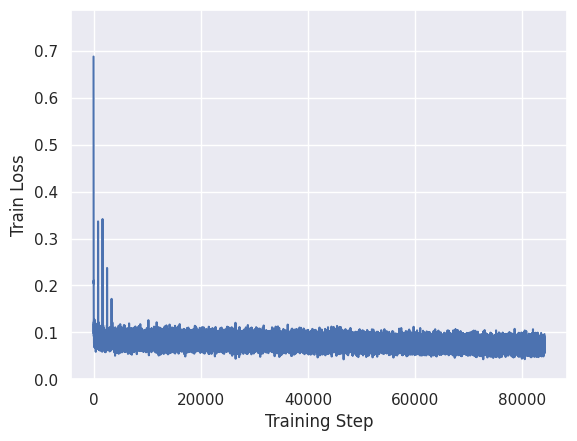

  0%|          | 0/141 [00:00<?, ?it/s]

predictions (2242, 512)
true_predictions (646033,)
true_targets (646033,)


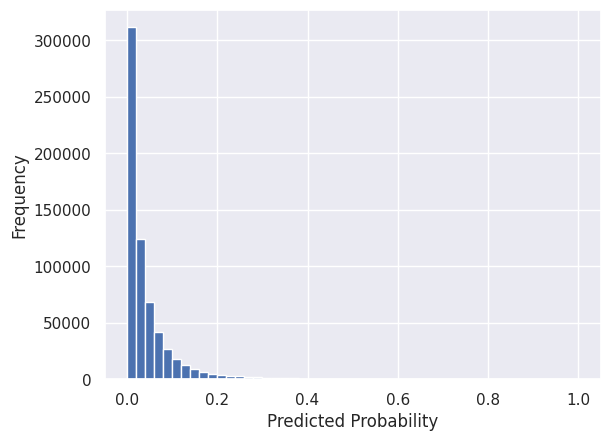

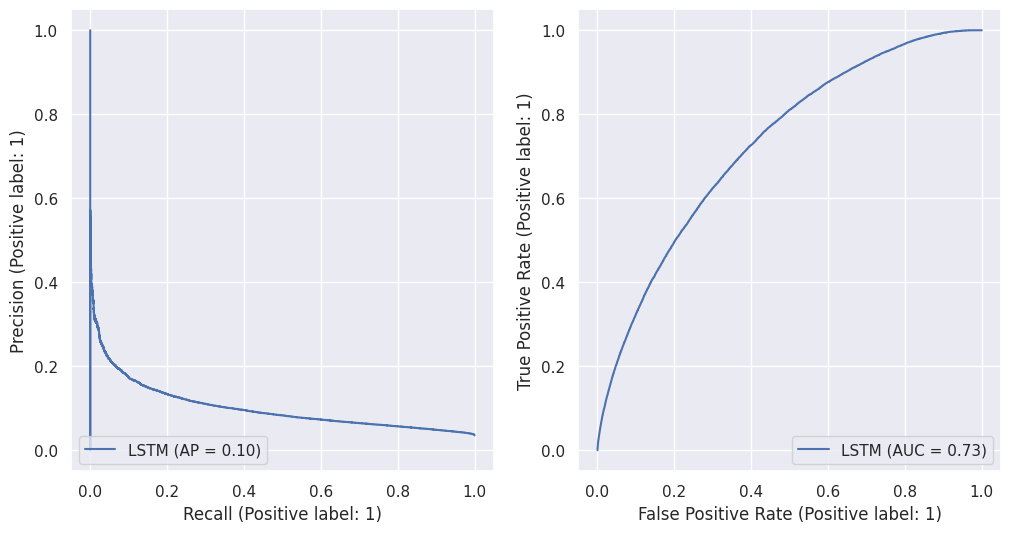

In [23]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = 768,
            hidden_size = 500,
            num_layers = 2,
            bidirectional = True
        )
        self.out_layer = nn.Linear(1000, 1)
        
    def forward(self, x):
        x, (last_hidden, last_memory) = self.lstm(x)
#         print(x)
        return self.out_layer(x).sigmoid()
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr = 10**-4)
#         return optimizer
    
#     def training_step(self, train_batch, batch_idx):
#         x, y = train_batch
#         x = self.forward(x)

clf = LSTM()
clf.cuda()
print(f"parameters: {sum([x.numel() for x in clf.parameters()]):,}")    

clf.cuda()
clf.train()

epochs = 100
lr = 10 ** -4

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr = lr)
bar = tqdm(total = epochs * len(loader))
plot = []
for i in range(1, epochs + 1):
    losses = []
    for x, y in (iter(loader)):
        preds = clf(x).squeeze()
#         print(preds.shape)
#         print(y.shape)
        loss = criterion(preds, y.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        plot.append(loss.item())
        bar.update(1)
    epoch_loss = sum(losses) / len(losses)
#     plot.append(epoch_loss)
    print(f"epoch {i}, loss {epoch_loss:.6f}", end = "\r")

plt.plot(plot)
plt.ylim(0, max(plot) + 0.1)
plt.ylabel("Train Loss")
plt.xlabel("Training Step")
plt.show()

# results

test_dataset = tud.TensorDataset(X_test)
test_loader = tud.DataLoader(test_dataset, batch_size = 16)
predictions = []
for (b,) in tqdm(test_loader):
    p = clf(b.cuda()).cpu().detach().numpy().squeeze()
    predictions.append(p)
predictions = np.concatenate(predictions)
print("predictions", predictions.shape)

# clf.cpu()
# predictions = clf(X_test).cpu().detach().numpy().squeeze()
# predictions.shape

relevance_test.map(len).sum()

true_predictions = np.concatenate([p[:len(l)] for p, l in zip(predictions, relevance_test)])
print("true_predictions", true_predictions.shape)

true_targets = np.concatenate(relevance_test.to_list())
print("true_targets", true_targets.shape)

plt.hist(true_predictions, range = (0, 1), bins = 50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

display = PrecisionRecallDisplay.from_predictions(
    true_targets, true_predictions, name = "LSTM",
    ax = axes[0]
)

display = RocCurveDisplay.from_predictions(
    true_targets, true_predictions, name = "LSTM",
    ax = axes[1]
)

In [22]:
name = "evaluation/lstm_test.npy"
print(f"Saving to {name}...")
np.save(name, true_predictions)

Saving to evaluation/lstm_test.npy...
